<a href="https://colab.research.google.com/github/merajsiddieque/ML-Lab/blob/main/ML_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [8]:
df = pd.read_csv('Housing.csv')

In [5]:
df.columns


Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [13]:
X = df.drop("price", axis=1)


In [14]:
# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Mean-center
mu = np.mean(X_scaled, axis=0)
A = X_scaled - mu

In [17]:
# Covariance matrix
C = np.dot(A.T, A)

In [18]:
# Eigen decomposition
eigvals, eigvecs = np.linalg.eigh(C)

In [19]:
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

In [22]:
# Function to compute reconstruction error for top n eigenvectors
def reconstruction_error(A, eigvecs, n):
    # take top n eigenvectors
    E = eigvecs[:, :n]

    errors = []
    for i in range(A.shape[0]):
        ai = A[i, :]
        # projection on eigenspace
        w = np.dot(E.T, ai)
        # linear combination
        li = np.dot(E, w)
        # reconstruction
        ri = li + mu
        # error (squared norm)
        err = np.linalg.norm((ai + mu) - ri) ** 2
        errors.append(err)

    return np.mean(errors)

In [23]:
# Experiment with different n
n_values = [1, 2, 3, 5, 7, 10, 15]
errors = {n: reconstruction_error(A, eigvecs, n) for n in n_values}

In [24]:
print("Reconstruction Errors for Housing.csv:")
for n, err in errors.items():
    print(f"n={n}: {err:.4f}")

Reconstruction Errors for Housing.csv:
n=1: 10.5303
n=2: 8.9575
n=3: 7.4574
n=5: 5.0970
n=7: 3.3809
n=10: 1.3663
n=15: 0.0000


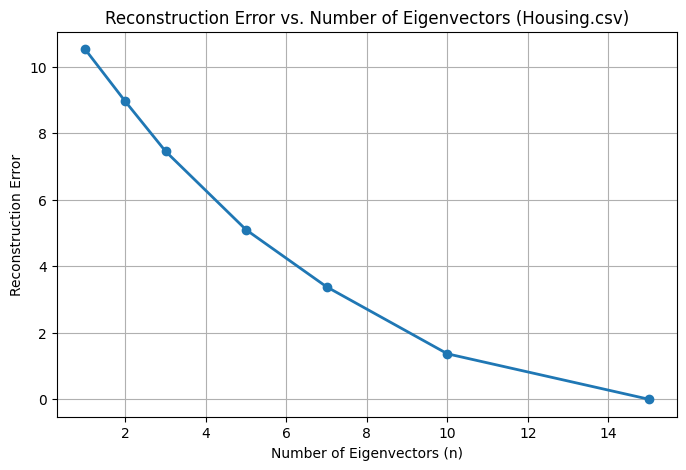

In [25]:
import matplotlib.pyplot as plt

# Plot reconstruction error graph
plt.figure(figsize=(8,5))
plt.plot(list(errors.keys()), list(errors.values()), marker='o', linestyle='-', linewidth=2)
plt.xlabel("Number of Eigenvectors (n)")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error vs. Number of Eigenvectors (Housing.csv)")
plt.grid(True)
plt.show()


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [27]:
# ---------- Utility functions ----------
def mse_loss(X, y, w):
    y_pred = X @ w
    return np.mean((y - y_pred) ** 2)

def gradient(X, y, w):
    return -(2 / X.shape[0]) * (X.T @ (y - X @ w))

In [28]:
def gradient_descent(X, y, lr=0.01, epochs=100, tol=1e-6):
    w = np.zeros((X.shape[1], 1))
    losses = []
    for _ in range(epochs):
        grad = gradient(X, y, w)
        w -= lr * grad
        losses.append(mse_loss(X, y, w))
        if len(losses) > 2 and abs(losses[-2] - losses[-1]) < tol:
            break
    return w, losses

In [29]:
def momentum_gd(X, y, lr=0.01, gamma=0.9, epochs=100, tol=1e-6):
    w = np.zeros((X.shape[1], 1))
    v = np.zeros_like(w)
    losses = []
    for _ in range(epochs):
        grad = gradient(X, y, w)
        v = gamma * v + lr * grad
        w -= v
        losses.append(mse_loss(X, y, w))
        if len(losses) > 2 and abs(losses[-2] - losses[-1]) < tol:
            break
    return w, losses

In [30]:
def nag(X, y, lr=0.01, gamma=0.9, epochs=100, tol=1e-6):
    w = np.zeros((X.shape[1], 1))
    v = np.zeros_like(w)
    losses = []
    for _ in range(epochs):
        grad = gradient(X, y, w - gamma * v)
        v = gamma * v + lr * grad
        w -= v
        losses.append(mse_loss(X, y, w))
        if len(losses) > 2 and abs(losses[-2] - losses[-1]) < tol:
            break
    return w, losses

In [42]:
# Load dataset
df = pd.read_csv("/content/advertising.csv").dropna()


In [43]:

# Separate X, y
y = df["Sales"].values.reshape(-1, 1)   # Sales for advertising dataset, price for Housing
X = df.drop("Sales", axis=1)

In [44]:
# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

In [45]:
# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [46]:
# Add bias term (intercept)
X = np.c_[np.ones(X.shape[0]), X]

In [47]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Run optimizers
_, loss_gd = gradient_descent(X_train, y_train, lr=0.01, epochs=200)
_, loss_momentum = momentum_gd(X_train, y_train, lr=0.01, gamma=0.9, epochs=200)
_, loss_nag = nag(X_train, y_train, lr=0.01, gamma=0.9, epochs=200)

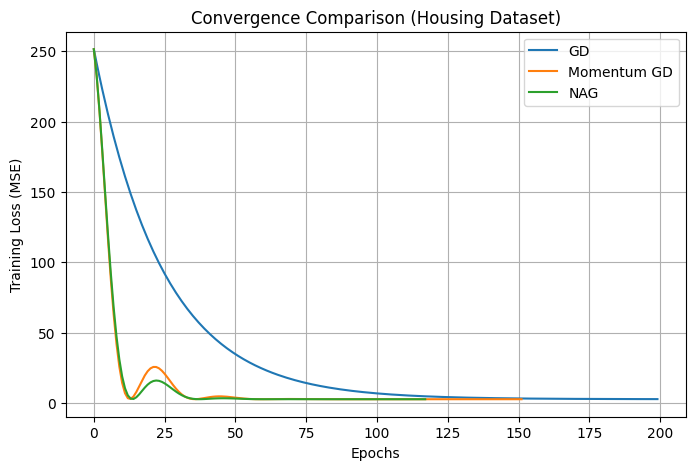

In [49]:
# Plot comparison
plt.figure(figsize=(8,5))
plt.plot(loss_gd, label="GD")
plt.plot(loss_momentum, label="Momentum GD")
plt.plot(loss_nag, label="NAG")
plt.xlabel("Epochs")
plt.ylabel("Training Loss (MSE)")
plt.title("Convergence Comparison (Housing Dataset)")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
df1 = pd.read_csv('/content/faa_ai_prelim.csv')
df1.columns

Index(['UPDATED', 'ENTRY_DATE', 'EVENT_LCL_DATE', 'EVENT_LCL_TIME',
       'LOC_CITY_NAME', 'LOC_STATE_NAME', 'LOC_CNTRY_NAME', 'RMK_TEXT',
       'EVENT_TYPE_DESC', 'FSDO_DESC', 'REGIST_NBR', 'FLT_NBR', 'ACFT_OPRTR',
       'ACFT_MAKE_NAME', 'ACFT_MODEL_NAME', 'ACFT_MISSING_FLAG',
       'ACFT_DMG_DESC', 'FLT_ACTIVITY', 'FLT_PHASE', 'FAR_PART', 'MAX_INJ_LVL',
       'FATAL_FLAG', 'FLT_CRW_INJ_NONE', 'FLT_CRW_INJ_MINOR',
       'FLT_CRW_INJ_SERIOUS', 'FLT_CRW_INJ_FATAL', 'FLT_CRW_INJ_UNK',
       'CBN_CRW_INJ_NONE', 'CBN_CRW_INJ_MINOR', 'CBN_CRW_INJ_SERIOUS',
       'CBN_CRW_INJ_FATAL', 'CBN_CRW_INJ_UNK', 'PAX_INJ_NONE', 'PAX_INJ_MINOR',
       'PAX_INJ_SERIOUS', 'PAX_INJ_FATAL', 'PAX_INJ_UNK', 'GRND_INJ_NONE',
       'GRND_INJ_MINOR', 'GRND_INJ_SERIOUS', 'GRND_INJ_FATAL', 'GRND_INJ_UNK'],
      dtype='object')